# Edge detection

first import the necessary modules

In [67]:
import numpy as np
import matplotlib.pylab as plt
from scipy.signal import convolve2d
import cv2

than we setup the loading path and display the image

In [95]:
img_liver_path = '../images/liver/liver_cirrhosis_1.png'
img_liver_healthy_path = '../images/liver/liver_healthy.png'
img_liver = cv2.imread(img_liver_path)
img_inverted = 255 - img_liver
img_gray = img_liver[:,:,0]

def show_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off') # we don't need an axis

create a kernel consisting of $n \times n$ ones and apply morphology closing to avoid noise.

In [132]:
closing_n = 80
kernel = np.ones((closing_n, closing_n), np.uint8)
closing = cv2.morphologyEx(img_inverted, cv2.MORPH_CLOSE, kernel)

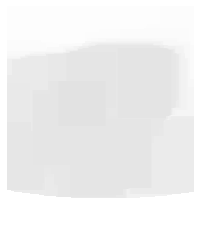

In [133]:
show_img(closing)

then apply the canny operator 
* gaussian blur
* gradient $G_x, G_y$ via sobel 
* gradient strength $\sqrt{G_x^2 + G_y^2}$ and direction $\arctan(\frac{G_y}{G_x})$
* non maximum supression, which removes pixels that should not be part of an edge 
* last step is called Hysteresis, it uses two parameters ( _upper_ and _lower_ ):
    - if pixel gradient higher than _upper_ $\rightarrow$ pixel accepted as edge 
    - if pixel gradient below _lower_ $\rightarrow$ pixel gets rejected
    - if pixel gradient between _lower_ and _upper_ $\rightarrow$ only accepted if pixel is connected to a pixel that is above _upper_

(Text(0.5, 1.0, 'only edges'), (-0.5, 327.5, 382.5, -0.5))

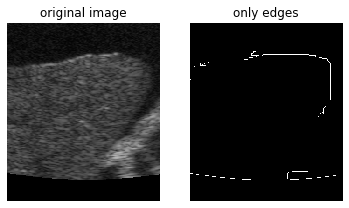

In [138]:
lower = 19
upper = 39
edges = cv2.Canny(closing, lower, upper)

plt.subplot(121), plt.imshow(img_liver, cmap='gray')
plt.title('original image'), plt.axis('off')
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('only edges'), plt.axis('off')

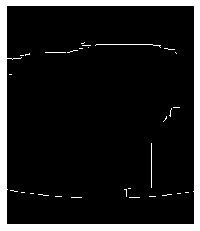

In [139]:
show_img(edges)

# Testing stuff here

---

## first blur the image

the image gets blured "inside" the canny algorithm but we can use gaussian blur to get rid of some noise inside the image before sending it to canny

(Text(0.5, 1.0, 'blured + canny'), (-0.5, 327.5, 382.5, -0.5))

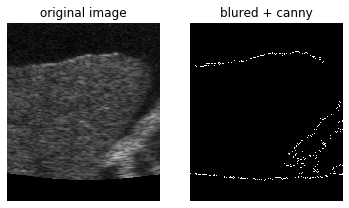

In [145]:
blur_n = 31 # has to be odd
img_blur = cv2.GaussianBlur(img_gray, (blur_n,blur_n), 0)

blur_canny = cv2.Canny(img_blur, 20, 30)
show_img(blur_canny)

plt.subplot(121), plt.imshow(img_liver, cmap='gray')
plt.title('original image'), plt.axis('off')
plt.subplot(122), plt.imshow(blur_canny, cmap='gray')
plt.title('blured + canny'), plt.axis('off')

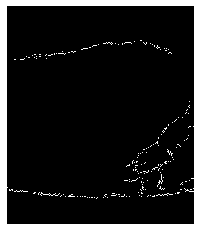

In [146]:
show_img(blur_canny)

the result seems to be nicer but the edge is not as sharp as expected

## Harris Corner Detection

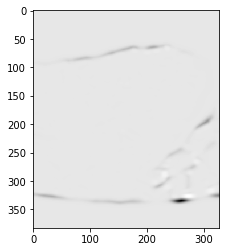

In [130]:
block_size = 8 # size of neighbourhood
ksize = 15 # aperture parameter of sobel, has to be odd
k = 0.06 # free parameter
dst = cv2.cornerHarris(img_blur, block_size, ksize, k)
dst = cv2.dilate(dst, None)

plt.imshow(dst, cmap = 'gray')

## Scharr operator

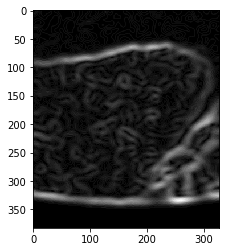

In [131]:
scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],
                   [-10+0j, 0+ 0j, +10 +0j],
                   [ -3+3j, 0+10j,  +3 +3j]])

grad = convolve2d(img_blur, scharr, boundary='symm', mode='same')
plt.imshow(np.absolute(grad), cmap='gray')

## Discrete fourier transform

from [here](https://akshaysin.github.io/fourier_transform.html) honestly no idea what its doing and results dont look too good to me. Maybe i am doing something wrong here.

In [103]:
dft = cv2.dft(np.float32(img_gray), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

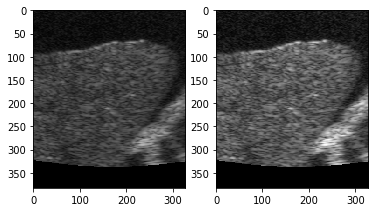

In [104]:
rows, cols = img_blur.shape
crow, ccol = int(rows / 2), int(cols / 2)  # center

# Circular HPF mask, center circle is 0, remaining all ones

mask = np.ones((rows, cols, 2), np.uint8)
r = 80
center = [crow, ccol]
x, y = np.ogrid[:rows, :cols]
mask_area = (x - center[0]) ** 3 + (y - center[1]) ** 3 <= r*r
mask[mask_area] = 1

# apply mask and inverse DFT
fshift = dft_shift * mask

f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])


fig_dft, axs_dft = plt.subplots(nrows=1,ncols=2)
axs_dft[0].imshow(img_liver)
axs_dft[1].imshow(img_back, cmap='gray')